# Train an Artificial Neural Network

In this exercise, we will demonstrate how to implement an artifical neural network using Python. We will train a neural network for regression containing one hidden layer, using vanilla gradient descent.

Execute the code cells below to import some modules.

In [1]:
%load_ext autoreload

In [2]:
%autoreload 2
import numpy as np
from numpy.matlib import repmat
import sys
import matplotlib.pyplot as plt
from scipy.io import loadmat
import time

from helper import *

%matplotlib inline


<h3>Loading and Visualizing the Data Set</h3>
<p>In the cell below, we generated a simple 1-dimensional toy dataset by calling <code>generate_data</code>. This function returns the data $\mathbf{X}$ and label $\mathbf{y}$. Note that $\mathbf{X}$ is of shape (N, 2). We append 1 to each example to introduce bias.</p>

In [3]:
X, y = generate_data()

print(f'The shape of X is {X.shape}. This is because we append 1 to each feature vector to introduce bias!')

The shape of X is (50, 2). This is because we append 1 to each feature vector to introduce bias!


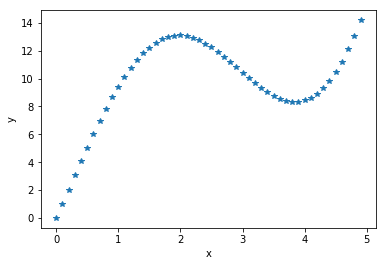

In [4]:
plt.plot(X[:, 0], y, '*')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

<h2>Artifical Neural Network</h2>

<h3>Step 1: Transition Function and Transition Function's gradient</h3>
<p>Transition functions are the key component of a neural network that contributes to its nonlinearity. For our neural network, we are going to use the ReLU transition function. Recall that the ReLU transition is as follows:</p>
$$\sigma(z) = \max(z, 0)$$

<p>We have implemented the <code>ReLU</code> and <code>ReLU_grad</code> functions as follow: (As its name suggests,  <code>ReLU_grad</code> computes the gradient of the ReLU function.)</p>

In [5]:
def ReLU(z):
    return np.maximum(z, 0)

In [6]:
def ReLU_grad(z):
    return (z > 0).astype('float64')

<h4>Visualize the Transition Function</h4>
We can now visualize the transition function in the plot above by running the code in the cell below.

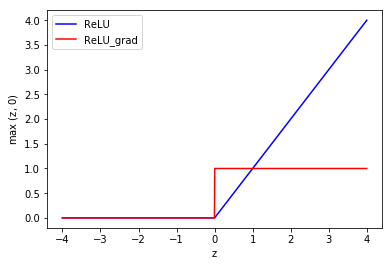

In [7]:
plt.plot(np.linspace(-4, 4, 1000), ReLU(np.linspace(-4, 4, 1000)),'b-')
plt.plot(np.linspace(-4, 4, 1000), ReLU_grad(np.linspace(-4, 4, 1000)),'r-')
plt.xlabel('z')
plt.ylabel(r'$\max$ (z, 0)')
plt.legend(['ReLU','ReLU_grad'])

We can also display the function and its gradient on a small example vector:

In [8]:
x=np.array([2.7,-0.5,-3.2])
print('X:',x)
print('ReLU(X):',ReLU(x))
print('ReLU_grad(X):',ReLU_grad(x))

X: [ 2.7 -0.5 -3.2]
ReLU(X): [2.7 0.  0. ]
ReLU_grad(X): [1. 0. 0.]


<h3>Step 2: Forward Pass</h3>

In this section, we will implement the forward pass function <code>forward_pass(W, xTr)</code>. Note that $\mathbf{W}$ specifies the weights of the network at each layer. More specifically, $W[0]$ stores the weights for the first layer of the network, $W[i]$ stores the weights of the (i + 1)-th layer and $W[l-1]$ stores the weights of the last layer.

Each layer of the network produces two outputs, $A[i + 1]$ and 
$Z[i + 1]$, where 

$$A[i + 1] = Z[i] * W[i]$$ for $i = 0, 1, 2, ..., l-1$ and 
$$Z[i+1] = \sigma(A[i+1])$$ for $i = 0, 1, 2, ..., l-2$ and 
$$Z[l-1] = A[l-1]$$


Here, $*$ stands for matrix multiplication and $Z[0], A[0]$ are both initialized to be the the training set.

For simplicity, we did not include bias when calculating $A[i + 1]$. For the purpose of this demo, this is fine since we have appended one in all the raw features and  our dataset is rather simple. In general, bias should always be included when calculating $A[i + 1]$

To visualize the variables $A$, $Z$, and $W$ a bit better, consider the following hypothetical neural net layer:
![nnlayer.png](nnlayer.png)

It is important to note that $W[i]$ is an *array of matrices*, as specified in the docstring for the provided method `initweights`. Since layer $i$ has 2 nodes and layer $i+1$ has 3, $W[i]$ is a 2 by 3 matrix.

Additionally, $\sigma$ is applied elementwise to the values in $A[i+1]$, and is `ReLU` for this assignment. The final output at the end of the neural network should be $Z[l-1]$.

The following function will allow you to randomly generate initial weights for the neural network:

In [9]:
def initweights(specs):
    """
    Given a specification of the neural network, output a random weight array
    INPUT:
        specs - array of length m+1. specs[0] should be the dimension of the feature and spec[-1] 
                should be the dimension of output
    
    OUTPUT:
        W - array of length m, each element is a matrix
            where size(weights[i]) = (specs[i], specs[i+1])
    """
    W = []
    for i in range(len(specs) - 1):
        W.append(np.random.randn(specs[i], specs[i+1]))
    return W

In [10]:
# If we want to create a network that 
#   i) takes in feature of dimension 2
#   ii) has 1 hidden layer with 3 hidden units
#   iii) output a scalar
# then we initialize the the weights the following way:

W = initweights([2, 3, 1])

In the cell below, we implemented the forward pass function <code>forward_pass(W, xTr)</code>. Below is the pseudocode from the READ module: 

![fwdpass.png](fwdpass.png)

The algorithm looks like this after modifying the notation (for our purposes):

![fwdpass_mat.png](fwdpass_mat.png)

<h3>Important</h3>
A forward pass is used to evaluate a neural network on an input. However, here, we want to do a forward pass also to train a neural network, i.e. we will follow it with a backward pass. Therefore, unlike the pseudocode from the READ module, our code requires two changes. We output $A$ (a <b>list</b> of the outputs at each layer after multiplying by the weights) and $Z$ (a <b>list</b> of all outputs at each layer after passing the results of $A$ through our transition function). To be precise, the outputs of our function are $A=[A_0, A_1, \dots, A_{l-1}]$ and $Z=[Z_0, Z_1, \dots, Z_{l-1}]$. The reason we need these intermediate results is that it is much more efficient to not recompute them when we use them during the back-prop pass. 

In [11]:
def forward_pass(W, xTr):
    """
    function forward_pass(weights,xTr)
    
    INPUT:
    W - an array of L weight matrices
    xTr - nxd matrix. Each row is an input vector
    
    OUTPUTS:
    A - a list of matrices (of length L) that stores result of matrix multiplication at each layer 
    Z - a list of matrices (of length L) that stores result of transition function at each layer 
    """
    
    A = [xTr]
    Z = [xTr]
    for i in range(len(W)):
        a = Z[i] @ W[i]
        A.append(a)
        
        if i < len(W) - 1:
            z = ReLU(a)
        else:
            z = a

        Z.append(z)
    return A, Z

<h3>Step 3: MSE Loss and Gradient</h3>
<h4>Loss Function</h4>

In this section, we are going to implement the Mean Squared Error (MSE) loss function for regression. Recall that for a set of training example $\{(\mathbf{x}_1, y_1), ..., (\mathbf{x}_n, y_n)\}$, the MSE of the network $h$ is 

$$L = \frac{1}{n} \sum_{i = 1} ^n(h(\mathbf{x}_i) - y_i)^2$$

The <code>MSE</code> function takes the output of the network (<code>out</code>) and the training labels (<code>y</code>) and computes the MSE loss. We also implemented the <code>MSE_grad</code> function that will calculate the gradient of the MSE loss with respect to each entry of `out`. This function will be useful for backpropagation.

In [12]:
def MSE(out, y):
    """
    INPUT:
    out: output of network (n vector)
    y: training labels (n vector)
    
    OUTPUTS:
    
    loss: the mse loss (a scalar)
    """
    
    n = len(y)
    loss = 0
    loss = np.mean((out - y) ** 2)
   
    return loss

#### Gradient

In the function `MSE_grad`, we implemented the gradient of the MSE loss calculated above. When you take the derivative of the above with respect to the entries of out, you get the following:
$$\nabla L = \frac{2}{n} * (h(\mathbf{x}_i) - y_i)$$


In [13]:
def MSE_grad(out, y):
    """
    INPUT:
    out: output of network (n vector)
    y: training labels (n vector)
    
    OUTPUTS:
    
    grad: the gradient of the MSE loss with respect to out (nx1 vector)
    """
    
    n = len(y)
    grad = np.zeros(n)
    grad = 2 * (out - y) / n
   
    return grad

<h3> Step 4: Backpropagation</h3>

In this section, we are going to implement the <code>backprop</code> for a ReLU network specified by weights $\mathbf{W}$. To recap, this is the stage that updates all the weights in the network starting from the last layer. Again, our implementation will have slight tweaks from the one in the READ module on back propagation. 

![backpass.png](backpass.png)

The algorithm looks like this after modifying the notation:

![backpass_mat.png](backpass_mat.png)

* Recall that in backpropagation, for each layer $i$, we alternate between calculating a "link" ( $\frac{\partial L}{\partial \mathbf A_{i+1}}$) and updating the weight ($\mathbf{W}_i = \mathbf{W}_i - \alpha \frac{\partial L}{\partial \mathbf{W}_i}$). In this function, we only calculated the update $\frac{\partial L}{\partial \mathbf{W}_i}$, **without applying it**. In other words, we stored all the $\frac{\partial L}{\partial \mathbf{W}_i}$ for all $0 \le i \le l-2$, and returned them all in the list `gradients`.
* We have absorbed $b$ into $\mathbf W$, so we don't need to calculate its gradient explicitly (thus, we just ignored the second line in the for loop of the pseudocode!) 
* In our code `delta` = $\vec{\delta}_{i+1} = \frac{\partial L}{\partial \mathbf{A}_{i+1}}$.

In [14]:
def backprop(W, A, Z, y):
    """
    
    INPUT:
    W weights (cell array)
    A output of forward pass (cell array)
    Z output of forward pass (cell array)
    y vector of size n (each entry is a label)
    
    OUTPUTS:
    
    gradient = the gradient with respect to W as a cell array of matrices
    """
    
    # Convert delta to a row vector to make things easier
    delta = (MSE_grad(Z[-1].flatten(), y) * 1).reshape(-1, 1)

    # compute gradient with backprop
    gradients = []
    
    for i in range(len(W)-1, -1, -1):
        gradients.append((Z[i].T) @ (delta))
        delta = ReLU_grad(A[i]) * (delta@(W[i].T))
        
    gradients = gradients[::-1]
   
    return gradients

<h3>Step 5: Training with Gradient Descent</h3>

Run the cell below to train a ReLU Network for the task with Gradient Descent.

Elapsed time: 2.95s


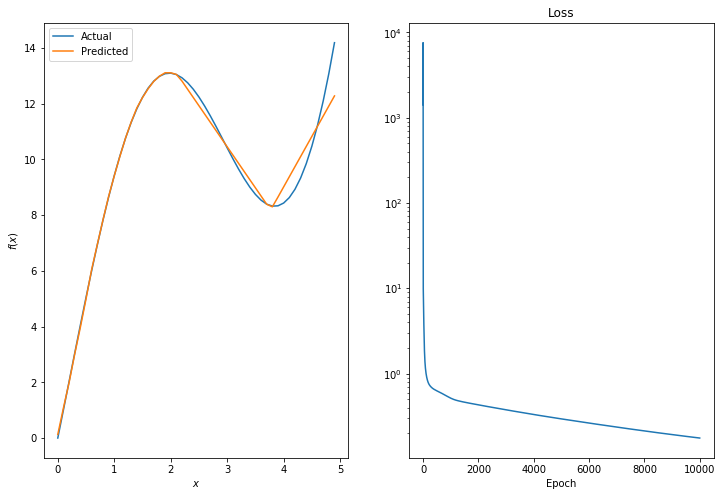

In [15]:
#generate data
X, y = generate_data() # generate data


# learning rate for Gradient Descent
lr = 0.001

# Number of epochs
# one epoch - one full pass through the dataset
M = 10000

# keep track of the losses
losses = np.zeros(M)
t0 = time.time()

# initialize a neural network with one hidden layer 
W = initweights([2, 200, 1])
W_init = [w.copy() for w in W]

# Start training
for i in range(M):
    
    # Do a forward pass
    A, Z = forward_pass(W, X)
    
    # Calculate the loss
    losses[i] = MSE(Z[-1].flatten(), y)
    
    # Calculate the loss using backprop
    gradients = backprop(W, A, Z, y)
    
    # Update the parameters
    for j in range(len(W)):
        W[j] -= lr * gradients[j]
t1 = time.time()
print('Elapsed time: %.2fs' % (t1-t0))
plot_results(X[:, 0], y, Z, losses)